# 시작

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

BATCH_SIZE = 16
IMAGE_WIDTH = 224
N_CLASS = 120
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 전처리

In [2]:
def normalize_and_resize(image, label):
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_WIDTH])
    return tf.cast(image, tf.float32) / 255., label


def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # image = tf.image.random_contrast(image, 0.2, 0.5)
    # image = tf.image.random_hue(image, max_delta=0.2)
    return image, label


def onehot(image, label):
    return image, tf.one_hot(label, N_CLASS)

In [3]:
def get_clip_box(max_x=IMAGE_WIDTH, max_y=IMAGE_WIDTH):
    x = tf.cast(tf.random.uniform([],0,max_x),tf.int32)
    y = tf.cast(tf.random.uniform([],0,max_y),tf.int32)

    width = tf.cast(max_x * tf.math.sqrt(1-tf.random.uniform([],0.25,0.75)),tf.int32)
    height = tf.cast(max_y * tf.math.sqrt(1-tf.random.uniform([],0.25,0.75)),tf.int32)
    
    left = tf.math.maximum(0, x-width//2)
    top = tf.math.maximum(0, y-height//2)
    right = tf.math.minimum(max_x, x+width//2)
    bottom = tf.math.minimum(max_y, y+width//2)
    
    return left, top, right, bottom

def mix_2_images(image1, image2, left, top, right, bottom):
    middle_left = image1[top:bottom,0:left,:]
    middle_center = image2[top:bottom,left:right,:]
    middle_right = image1[top:bottom,right:,:]
    middle_img = tf.concat([middle_left,middle_center,middle_right],axis=1)
    top_img = image1[0:top,:,:]
    bottom_img = image1[bottom:,:,:]
    return tf.concat([top_img, middle_img, bottom_img],axis=0)


def mix_2_label(label1, label2, left, top, right, bottom):
    mixed = (right-left) * (bottom-top)
    total = IMAGE_WIDTH * IMAGE_WIDTH
    ratio = tf.cast(mixed/total, tf.float32)
    if len(label1.shape)==0:
        label1 = tf.one_hot(label1, N_CLASS)
    if len(label2.shape)==0:
        label2 = tf.one_hot(label2, N_CLASS)
    return ((1 - ratio) * label1) + (ratio * label2)


def cutmix(image, label):
    mixed_imgs = []
    mixed_labels = []
    for i in range(BATCH_SIZE):
        image1 = image[i]
        label1 = label[i]
        j = tf.cast(tf.random.uniform([],0, BATCH_SIZE),tf.int32)
        image2 = image[j]
        label2 = label[j]
        left, top, right, bottom = get_clip_box()
        mixed_imgs.append(mix_2_images(image1, image2, left, top, right, bottom))
        mixed_labels.append(mix_2_label(label1, label2, left, top, right, bottom))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (BATCH_SIZE, IMAGE_WIDTH, IMAGE_WIDTH, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (BATCH_SIZE, N_CLASS))
    return mixed_imgs, mixed_labels

In [4]:
def mixup_2_images(image1, image2, label1, label2):
    a = tf.random.uniform([],0,1)
    if len(label1.shape)==0:
        label1 = tf.one_hot(label1, N_CLASS)
    if len(label2.shape)==0:
        label2 = tf.one_hot(label2, N_CLASS)
    mixed_image= ((1 - a) * image1) + (a * image2)
    mixed_label = ((1 - a) * label1) + (a * label2)
    return mixed_image, mixed_label


def mixup(image, label):
    mixed_imgs = []
    mixed_labels = []
    for i in range(BATCH_SIZE):
        image1 = image[i]
        label1 = label[i]
        j = tf.cast(tf.random.uniform([],0, BATCH_SIZE),tf.int32)
        image2 = image[j]
        label2 = label[j]
        mixed_img, mixed_label = mixup_2_images(image1, image2, label1, label2)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(BATCH_SIZE, IMAGE_WIDTH, IMAGE_WIDTH, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(BATCH_SIZE, N_CLASS))
    return mixed_imgs, mixed_labels

In [5]:
def preproceess_dataset(ds, mode=None):
    ds = ds.map(normalize_and_resize, num_parallel_calls=2)
    if mode in ['augment', 'cutmix', 'mixup']:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.batch(BATCH_SIZE)
    if mode == 'cutmix':
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif mode == 'mixup':
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if mode != 'test':
        ds = ds.repeat()
        ds = ds.shuffle(200)
    return ds.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 생성 & 훈련 & 결과보기

In [6]:
def make_model():
    model= tf.keras.models.Sequential([
        tf.keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(IMAGE_WIDTH, IMAGE_WIDTH,3),
            pooling='avg',
        ),
        tf.keras.layers.Dense(N_CLASS, activation = 'softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.2),
        metrics=['accuracy']
    )
    return model

In [7]:
def train_model(model, train, val, n_train, n_val, epochs=30):
    return model.fit(
        train,
        steps_per_epoch=int(n_train/BATCH_SIZE),
        validation_steps=int(n_test/BATCH_SIZE),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

In [8]:
def draw_history(names, histories):
    for history in histories:
        plt.plot(history.history['val_accuracy'])
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(names, loc='lower right')
    plt.show()

# 메인

In [9]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], 
                                          as_supervised=True, shuffle_files=True, with_info=True)
n_train = ds_info.splits['train'].num_examples
n_test = ds_info.splits['test'].num_examples

In [10]:
resnet_base = make_model()
resnet_aug = make_model()
resnet_cutmix = make_model()
resnet_mixup = make_model()

In [11]:
ds_train_base = preproceess_dataset(ds_train)
ds_train_aug = preproceess_dataset(ds_train, mode='augment')
ds_train_cutmix = preproceess_dataset(ds_train, mode='cutmix')
ds_train_mixup = preproceess_dataset(ds_train, mode='mixup')
ds_test = preproceess_dataset(ds_test, mode='test')

In [12]:
history_base = train_model(resnet_base, ds_train_base, ds_test, n_train, n_test)

Epoch 1/30
750/750 [==============================] - 111s 148ms/step - loss: 2.1197 - accuracy: 0.4582 - val_loss: 3.3036 - val_accuracy: 0.2310
Epoch 2/30
750/750 [==============================] - 112s 150ms/step - loss: 0.7437 - accuracy: 0.7850 - val_loss: 1.2828 - val_accuracy: 0.6341
Epoch 3/30
750/750 [==============================] - 113s 150ms/step - loss: 0.2784 - accuracy: 0.9312 - val_loss: 1.0368 - val_accuracy: 0.7036
Epoch 4/30
750/750 [==============================] - 113s 150ms/step - loss: 0.0980 - accuracy: 0.9847 - val_loss: 0.9714 - val_accuracy: 0.7194
Epoch 5/30
750/750 [==============================] - 113s 151ms/step - loss: 0.0337 - accuracy: 0.9975 - val_loss: 0.9215 - val_accuracy: 0.7435
Epoch 6/30
750/750 [==============================] - 113s 151ms/step - loss: 0.0224 - accuracy: 0.9975 - val_loss: 0.9558 - val_accuracy: 0.7371
Epoch 7/30
750/750 [==============================] - 113s 151ms/step - loss: 0.0163 - accuracy: 0.9989 - val_loss: 0.9625 -

In [13]:
history_aug = train_model(resnet_aug, ds_train_aug, ds_test, n_train, n_test)

Epoch 1/30
750/750 [==============================] - 114s 152ms/step - loss: 2.1826 - accuracy: 0.4439 - val_loss: 3.6173 - val_accuracy: 0.1837
Epoch 2/30
750/750 [==============================] - 114s 152ms/step - loss: 0.9722 - accuracy: 0.7153 - val_loss: 1.4253 - val_accuracy: 0.6067
Epoch 3/30
750/750 [==============================] - 114s 152ms/step - loss: 0.5452 - accuracy: 0.8423 - val_loss: 1.4401 - val_accuracy: 0.6059
Epoch 4/30
750/750 [==============================] - 114s 151ms/step - loss: 0.3140 - accuracy: 0.9166 - val_loss: 1.1056 - val_accuracy: 0.6896
Epoch 5/30
750/750 [==============================] - 113s 151ms/step - loss: 0.1674 - accuracy: 0.9601 - val_loss: 1.0344 - val_accuracy: 0.7160
Epoch 6/30
750/750 [==============================] - 113s 151ms/step - loss: 0.1047 - accuracy: 0.9787 - val_loss: 1.0592 - val_accuracy: 0.7114
Epoch 7/30
750/750 [==============================] - 113s 151ms/step - loss: 0.0679 - accuracy: 0.9869 - val_loss: 0.9984 -

In [14]:
history_cutmix = train_model(resnet_cutmix, ds_train_cutmix, ds_test, n_train, n_test)

Epoch 1/30
750/750 [==============================] - 117s 156ms/step - loss: 3.9540 - accuracy: 0.1906 - val_loss: 2.9759 - val_accuracy: 0.2712
Epoch 2/30
750/750 [==============================] - 116s 155ms/step - loss: 3.1891 - accuracy: 0.3711 - val_loss: 1.5049 - val_accuracy: 0.5891
Epoch 3/30
750/750 [==============================] - 116s 155ms/step - loss: 2.9537 - accuracy: 0.4408 - val_loss: 1.3872 - val_accuracy: 0.6258
Epoch 4/30
750/750 [==============================] - 117s 156ms/step - loss: 2.7546 - accuracy: 0.4975 - val_loss: 1.5952 - val_accuracy: 0.5714
Epoch 5/30
750/750 [==============================] - 116s 155ms/step - loss: 2.6461 - accuracy: 0.5347 - val_loss: 1.3960 - val_accuracy: 0.6226
Epoch 6/30
750/750 [==============================] - 117s 155ms/step - loss: 2.5473 - accuracy: 0.5613 - val_loss: 1.3538 - val_accuracy: 0.6348
Epoch 7/30
750/750 [==============================] - 117s 155ms/step - loss: 2.4405 - accuracy: 0.5936 - val_loss: 1.2237 -

In [15]:
history_mixup = train_model(resnet_mixup, ds_train_mixup, ds_test, n_train, n_test)

Epoch 1/30
750/750 [==============================] - 128s 171ms/step - loss: 3.7158 - accuracy: 0.2373 - val_loss: 3.7943 - val_accuracy: 0.1536
Epoch 2/30
750/750 [==============================] - 127s 169ms/step - loss: 2.9166 - accuracy: 0.4628 - val_loss: 1.8484 - val_accuracy: 0.5178
Epoch 3/30
750/750 [==============================] - 127s 169ms/step - loss: 2.6641 - accuracy: 0.5473 - val_loss: 1.4711 - val_accuracy: 0.5921
Epoch 4/30
750/750 [==============================] - 127s 169ms/step - loss: 2.4853 - accuracy: 0.6118 - val_loss: 1.7073 - val_accuracy: 0.5402
Epoch 5/30
750/750 [==============================] - 127s 169ms/step - loss: 2.3648 - accuracy: 0.6526 - val_loss: 1.3787 - val_accuracy: 0.6325
Epoch 6/30
750/750 [==============================] - 127s 169ms/step - loss: 2.2633 - accuracy: 0.6946 - val_loss: 1.2310 - val_accuracy: 0.6602
Epoch 7/30
750/750 [==============================] - 127s 169ms/step - loss: 2.2113 - accuracy: 0.7173 - val_loss: 1.3928 -

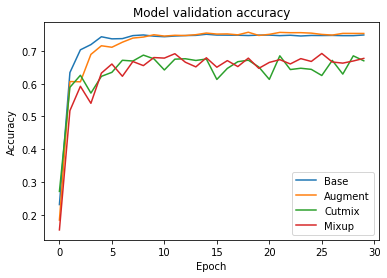

In [16]:
draw_history(['Base', 'Augment', 'Cutmix', 'Mixup'], [history_base, history_aug, history_cutmix, history_mixup])

# 결론

우선 cutmix와 mixup은 stanford_dogs 데이터 셋에 대해서는 좋지 않은 결과를 보였다.   
cutmix의 경우 이미지의 상당 부분을 해당 물체가 점유하고 있어야 훈련이 될 것으로 예측이 된다.  
cutmix가 적용된 크기, 위치에 따라 학습에 방해가 될 수도 있을 것으로 보인다.  
mixup의 경우도 혼합된 비율이나 혼합된 실제 이미지에 따라 잡음으로 보이는 경우가 있었다.  

augmentation만 적용한 결과는 그렇지 않은 경우보다 나아질 수도 있지만, 학습 초기에는 그렇지 못한 경향을 보인다.  
또, 어떤 augmentation을 적용하냐에 따라 성능에 크게 하락하기도 하였다.  

결론적으로 augmentation을 적용하는 것은 준비된 데이터 셋이 부족할때는 큰 도움이 되지만, augmentation의 종류가 하이퍼파라미터가 되는 꼴이므로 좋은 결과를 얻는데 더 많은 시도가 필요하다.  